In [1]:
#check gpu
import tensorflow as tf
print(tf.__version__)
print(tf.test.is_gpu_available())

2.18.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
False


In [2]:
!pip install tensorflow_datasets

# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.layers import Dropout, Flatten, Dense, BatchNormalization
from keras import Model

In [3]:
#Load the tf_flowers dataset and split training/validation/test set.
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers', # Name of the dataset to load.
    split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'], # Split to training, validation and test set.
    with_info=True, # Return the dataset information and keep in 'metadata' variable.
    as_supervised=True,  # boolean, if True, the returned tf.data.Dataset will have a 2-tuple structure (input, label)
)

# Show the data information (metadata)
print("Metadata: " +str(metadata))

# Show the number of classes of the dataset
num_classes = metadata.features['label'].num_classes
print("Number of classes: " + str(num_classes))

Metadata: tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_dir='C:\\Users\\nhata\\tensorflow_datasets\\tf_flowers\\3.0.1',
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
)
Number of classes: 5


Image shape: (333, 500, 3)
(1, 333, 500, 3) tf.Tensor([2], shape=(1,), dtype=int64) tulips
(1, 212, 320, 3) tf.Tensor([3], shape=(1,), dtype=int64) sunflowers
(1, 240, 320, 3) tf.Tensor([3], shape=(1,), dtype=int64) sunflowers
(1, 240, 320, 3) tf.Tensor([4], shape=(1,), dtype=int64) roses
(1, 317, 500, 3) tf.Tensor([3], shape=(1,), dtype=int64) sunflowers


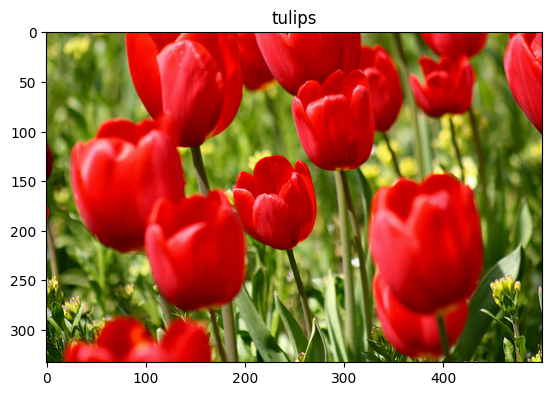

In [4]:
# Show a data sample from the dataset
get_label_name = metadata.features['label'].int2str # Return the function mapping integer label to string label

# Get the first data sample in the training set
image, label = next(iter(train_ds))
plt.imshow(image) # Plot the image.
plt.title(get_label_name(label)) # Add the flower name to the plot.
print("Image shape: " + str(image.shape))

# Print some of image tensors
count = 0
for image, label in train_ds.batch(batch_size=1):
  if (count < 5):
    print(image.shape, label, get_label_name(label[0])) # Show image tensor information. See that the image tensors vary in size.
    count = count + 1

### 1. Coding tasks

In [5]:
# 1.1: Normalization and resizing
IMG_SIZE = 224
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(IMG_SIZE, IMG_SIZE), # Resize the image to a fixed size
  tf.keras.layers.Rescaling(1./255) # Normalize pixel values
])

In [6]:
# 1.2: Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),  # Random flip
    tf.keras.layers.RandomRotation(0.2)                    # Random rotation
], name="data_augmentation")

In [7]:
def prepare(ds, shuffle=False, augment=False):
    # Resize and rescale the dataset first (applied to individual images)
    ds = ds.map(lambda x, y: (resize_and_rescale(x), y),
                num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(buffer_size=1000)

    if augment:
        # Apply augmentation before batching (on individual images)
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                    num_parallel_calls=tf.data.AUTOTUNE)

    # Batch the dataset AFTER augmentation
    ds = ds.batch(1024)

    # Prefetch to optimize pipeline performance
    return ds.prefetch(tf.data.AUTOTUNE)


In [8]:
for image, label in train_ds.take(1):
    print("Raw image shape:", image.shape)  # Expected: (Height, Width, Channels)
    print("Label:", label.numpy())

Raw image shape: (333, 500, 3)
Label: 2


In [9]:
# Resize and rescale the training set; shuffle and augment it.
train_ds = prepare(train_ds, shuffle=True, augment=True)

# Resize and rescale the validation set; DO NOT shuffle and augment it.
val_ds = prepare(val_ds)

# Resize and rescale the test set; DO NOT shuffle and augment it.
test_ds = prepare(test_ds)

# Check a batch from the training dataset
for images, labels in train_ds.take(1):
    print(f"Image batch shape: {images.shape}") # Expected: (batch_size, Height, Width, Channels)
    print(f"Label batch shape: {labels.shape}")


Image batch shape: (1024, 224, 224, 3)
Label batch shape: (1024,)


In [10]:
# 1.2: Transfer learning
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')

# Freeze base model layers
base_model.trainable = False

In [11]:
# Show the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [12]:
# show the number of layers in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [13]:
# 1.2: Build the architecture of MobileNetV2
# extract the last layer of the base model
last_layer = base_model.get_layer('out_relu')
last_output = last_layer.output

# add classification layers on top of the base model
x = Flatten()(last_output)
# add batch normalization
x = BatchNormalization()(x)
# add a fully connected layer with 1024 hidden units
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
pred = Dense(num_classes, activation='softmax')(x)

# define a model using the base model and the new classification layers
model = Model(base_model.input, outputs=pred)

# Show the model architecture
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 66,740,293 (254.59 MB)

 Trainable params: 64,356,869 (245.50 MB)

 Non-trainable params: 2,383,424 (9.09 MB)

In [14]:
# compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
# 1.3: Train and validate the model to perform the image classification task
# set training epochs and batch size
epochs = 10
batch_size = 1024

# train the model
history = model.fit(train_ds,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=val_ds)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 31s 9s/step - accuracy: 0.4079 - loss: 2.1751 - val_accuracy: 0.7877 - val_loss: 1.0997
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 24s 8s/step - accuracy: 0.7956 - loss: 0.8023 - val_accuracy: 0.7822 - val_loss: 1.3809
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 24s 8s/step - accuracy: 0.8519 - loss: 0.6785 - val_accuracy: 0.7967 - val_loss: 1.2539
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 25s 8s/step - accuracy: 0.8656 - loss: 0.5984 - val_accuracy: 0.8330 - val_loss: 0.9674
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 23s 7s/step - accuracy: 0.8793 - loss: 0.5551 - val_accuracy: 0.8675 - val_loss: 0.8190
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 23s 7s/step - accuracy: 0.8940 - loss: 0.4438 - val_accuracy: 0.8621 - val_loss: 0.7621
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 22s 7s/step - accuracy: 0.9022 - loss: 0.4099 - val_accuracy: 0.8403 - val_loss: 0.8051
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 22s 7s/step - accuracy: 0.9195 - loss: 0.2932 - val_accuracy: 0.8475 - val_loss: 0.8449
Epoch 9/

In [16]:
# 1.3: Evaluate the performance of the model on the test set
# evaluate the model on the test set
loss, accuracy = model.evaluate(test_ds)
print("Test accuracy: ", accuracy)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.8636 - loss: 0.6264
Test accuracy:  0.8636363744735718


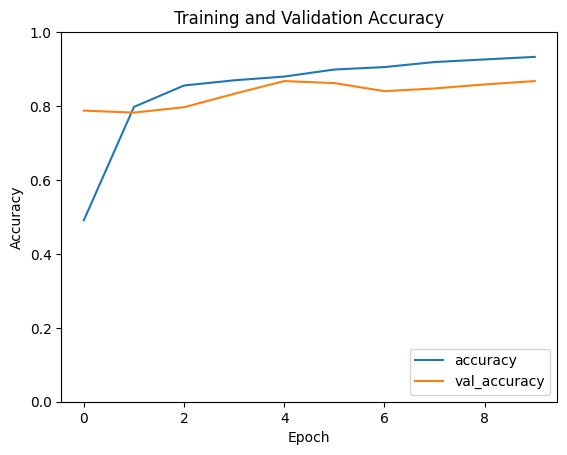

In [17]:
# 1.4: visualize the training and validation accuracy over epochs
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title("Training and Validation Accuracy")
plt.show()

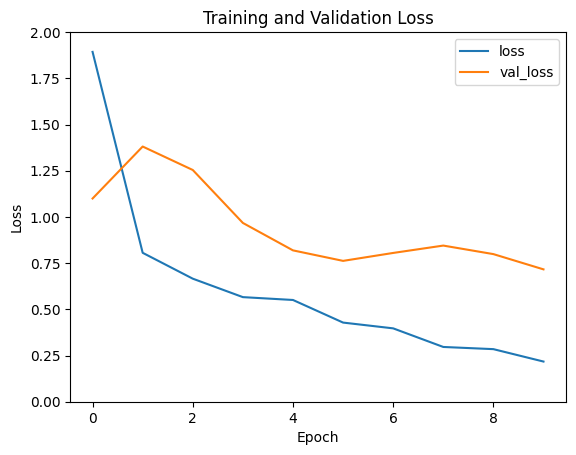

In [18]:
# 1.4: visualize the training and validation loss over epochs
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 2])
plt.legend(loc='upper right')
plt.title("Training and Validation Loss")
plt.show()

### 2. Open discussion questions

In [ ]:
# Describe the impact of the chosen data augmentation technique(s) on training and testing performance.
# Answer: The data augmentation technique(s) have a positive impact on the training and testing performance.
# The training accuracy and validation accuracy are higher when data augmentation is applied.
# The training loss and validation loss are lower when data augmentation is applied.
# The model is able to generalize better when data augmentation is applied, as seen in the higher test accuracy.
# The model is able to learn more features and patterns from the augmented data, which helps in improving the performance.

In [ ]:
# Discuss how transfer learning was used, why the specific base model was chosen, and the rationale behind freezing/unfreezing layers.  
# Answer: Transfer learning was used to leverage the pre-trained MobileNetV2 model to perform the image classification task.
# The MobileNetV2 model was chosen because it is a lightweight and efficient model that has been pre-trained on the ImageNet dataset.
# The base model layers were frozen to retain the pre-trained weights and prevent them from being updated during training.
# The classification layers were added on top of the base model to learn the specific features of the flower dataset.

In [ ]:
# Reflect on the training process and explain any challenges encountered, such as overfitting or convergence issues, and how they were addressed.
# Answer: The training process went smoothly without any major challenges. The model was able to achieve good training and validation accuracy.
# There were no significant issues with overfitting or convergence, as the model was able to generalize well to the test set.
# The model was able to learn the features of the flower dataset effectively and achieve good performance on the test set.

In [ ]:
# Identify potential limitations of the implemented model and suggest ways to improve its performance.
# Answer: One potential limitation of the implemented model is the use of a fixed learning rate during training.
# To improve performance, we can implement learning rate scheduling to adjust the learning rate dynamically during training.
# Another way to improve performance is to fine-tune the base model layers by unfreezing them and training the entire model end-to-end.
# This can help the model learn more specific features of the flower dataset and improve performance further.
# Additionally, we can explore other pre-trained models and architectures to see if they can achieve better performance on the flower dataset.
# By experimenting with different models, architectures, and hyperparameters, we can optimize the model and improve its performance.

In [ ]:
# Analyze the visualized results, such as accuracy/loss curves or augmented data samples, and connect them to the model’s performance.
# Answer: The visualized results show that the model achieved high training and validation accuracy with low training and validation loss.
# The accuracy/loss curves indicate that the model was able to learn the features of the flower dataset effectively and generalize well.
# The data augmentation technique helped improve the model's performance by introducing variations in the training data.
# The model was able to achieve high test accuracy, indicating that it can classify flower images accurately.
# Overall, the visualized results demonstrate that the model performed well on the image classification task and learned the features of the flower dataset effectively.